**V2 Testing**

🚀 Pulmonary Fibrosis Progression Analysis
1549 Rows and 7 Columns in train data

Train data sample:


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker



Train data statistics:


,Weeks,FVC,Percent,Age
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509
std,23.247550,832.770959,19.823261,7.057395
min,-5.000000,827.000000,28.877577,49.000000
25%,12.000000,2109.000000,62.832700,63.000000
50%,28.000000,2641.000000,75.676937,68.000000
75%,47.000000,3171.000000,88.621065,72.000000
max,133.000000,6399.000000,153.145378,88.000000


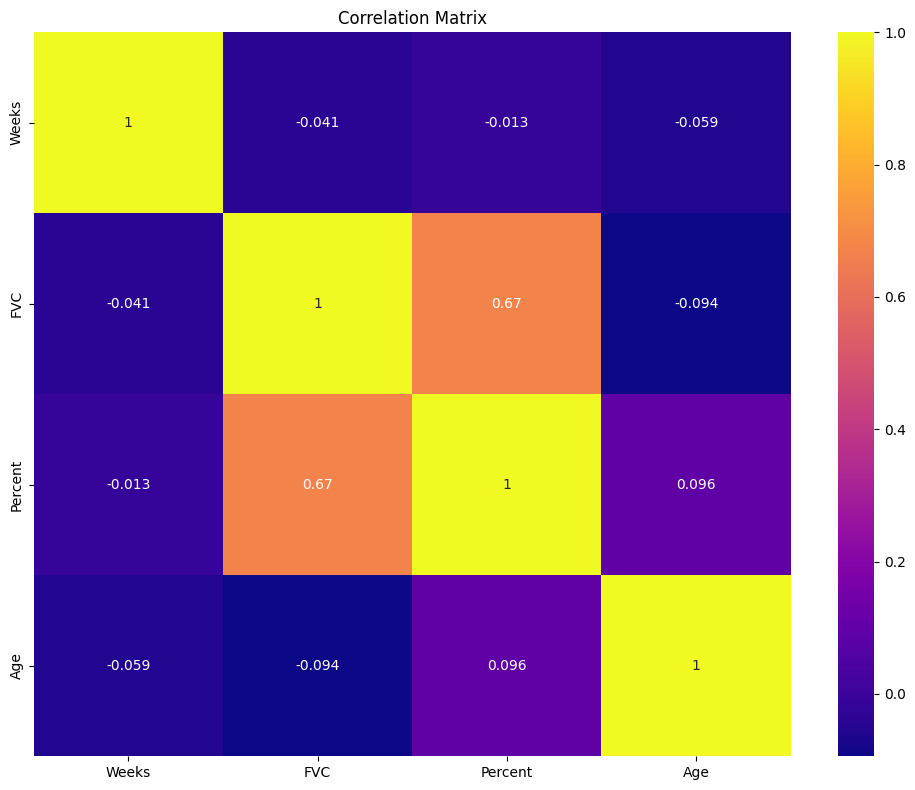

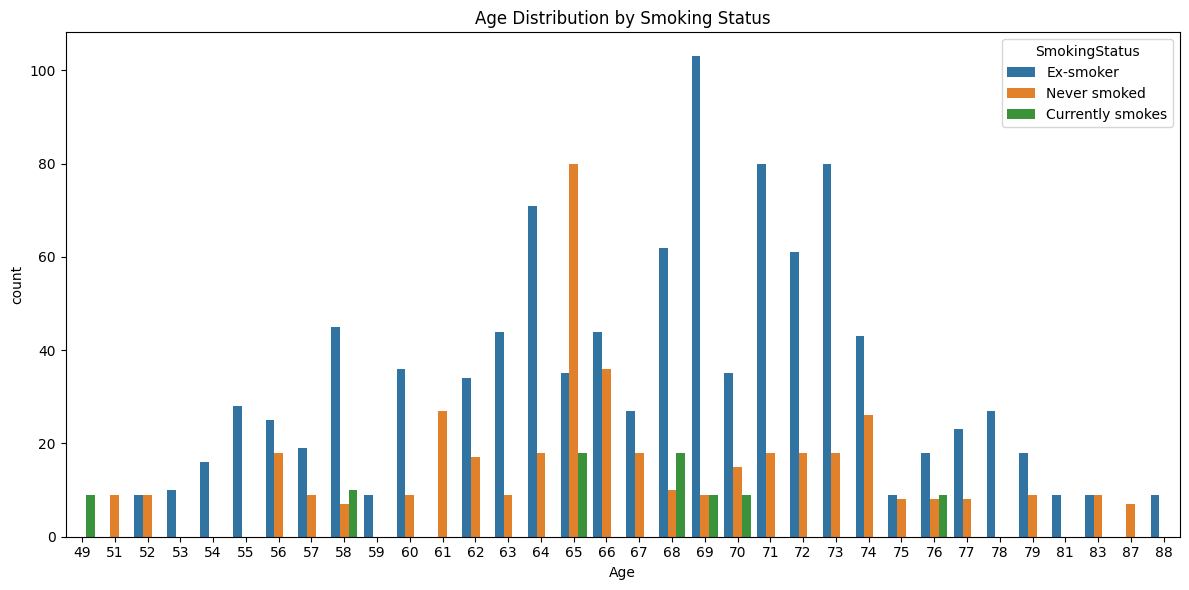

The Number of Unique Patients in training data: 176


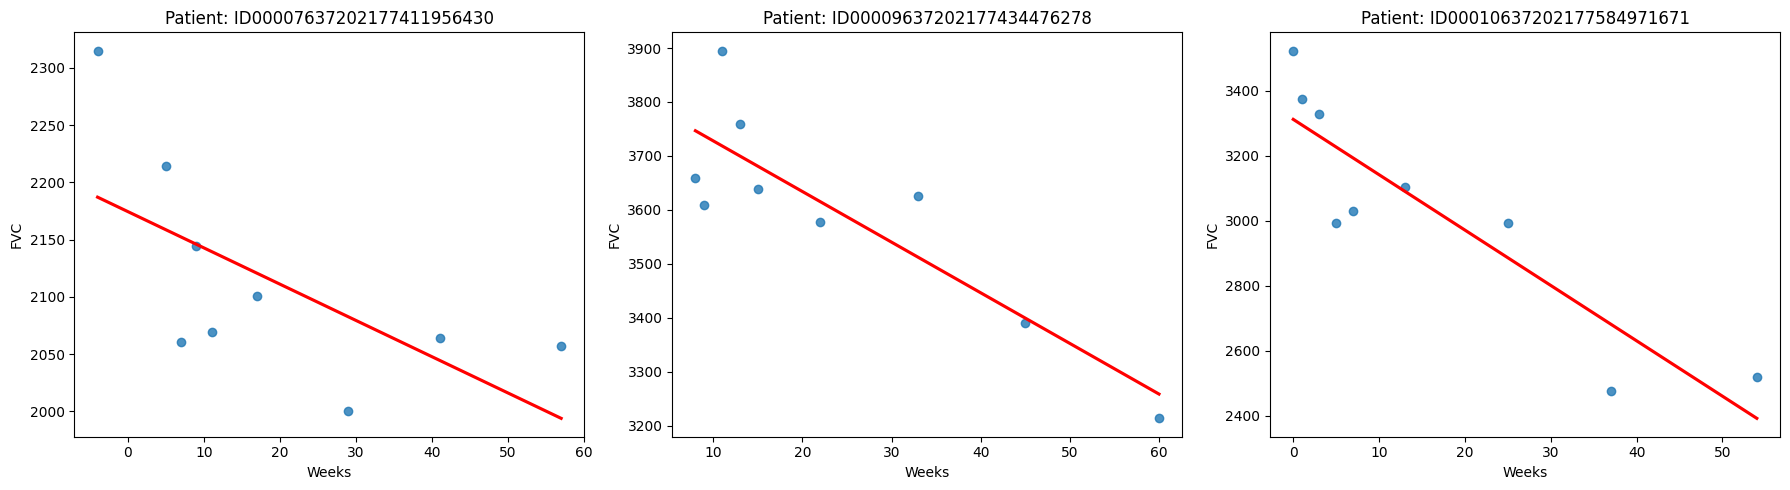

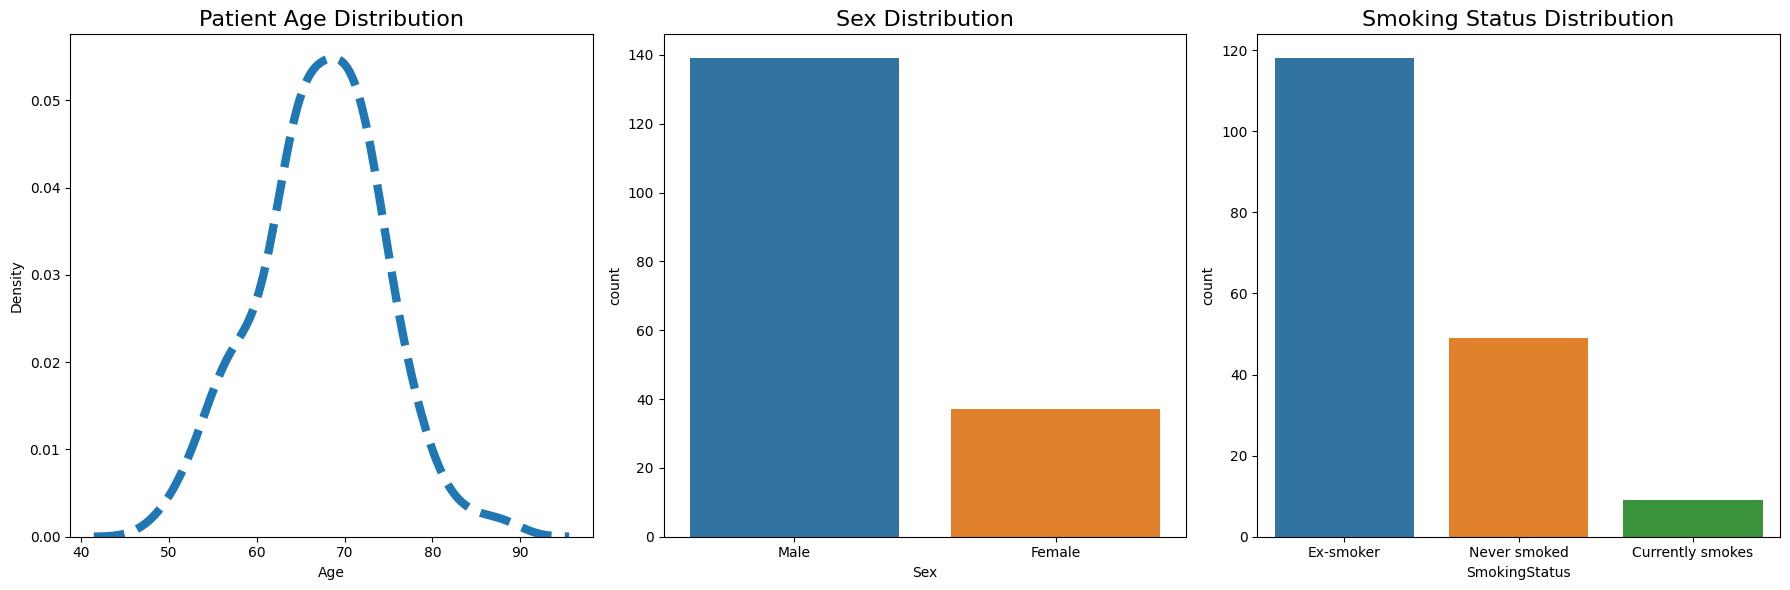

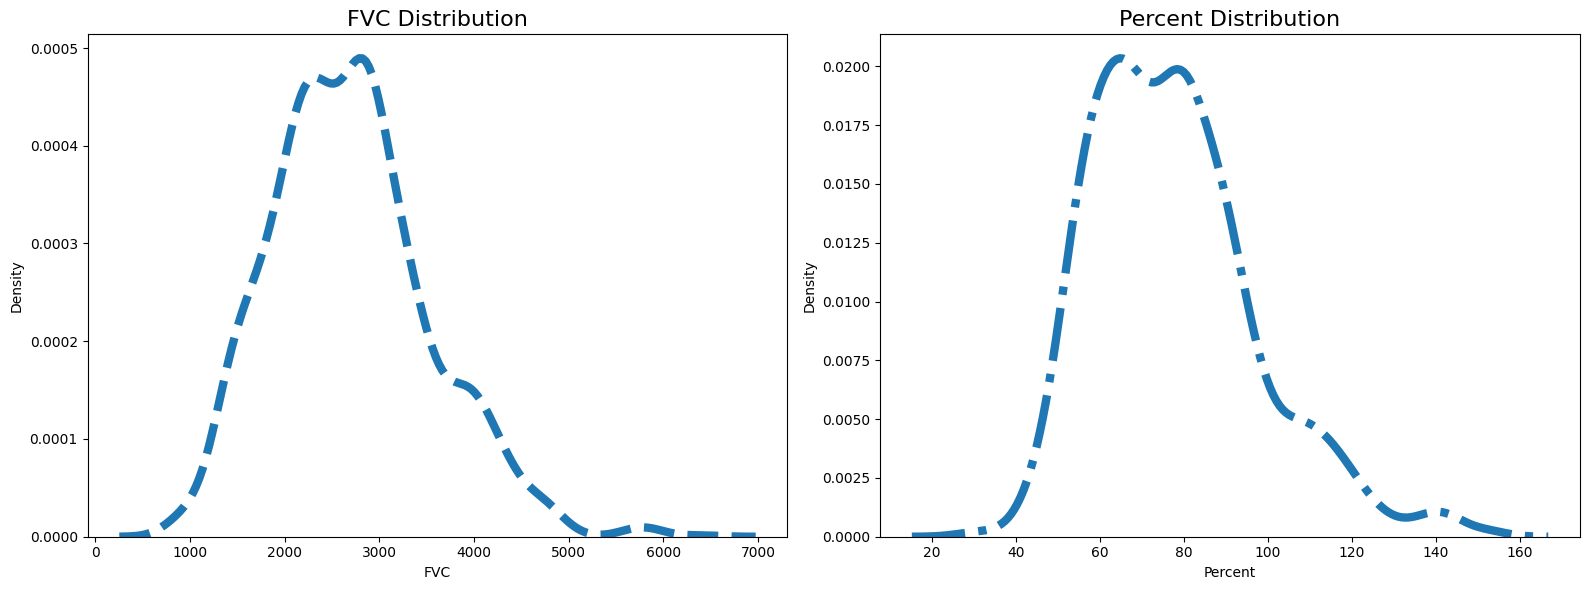

Train split: 112 patients (63.6%)
Validation split: 28 patients (15.9%)
Test split: 36 patients (20.5%)


In [16]:
# Pulmonary Fibrosis Progression: EDA, Modeling & Submission
# This notebook combines the best EDA/visualization from V2 with the full modeling pipeline from V1.
# 1. Data Loading & Exploratory Data Analysis (EDA)
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import random
from tqdm import tqdm 
from datetime import timedelta, datetime
from pathlib import Path
import json
import warnings
import pickle
import glob
# Image processing
from skimage import measure, morphology, segmentation
from skimage.transform import resize
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans
from skimage.segmentation import clear_border
# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
# Albumentations for medical augmentations
import albumentations as albu
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings('ignore')
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed_everything(42)
DATA_DIR = Path("../input/osic-pulmonary-fibrosis-progression")
TRAIN_DIR = DATA_DIR / "train"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Pulmonary Fibrosis Progression Analysis")
# Load dataset
train_df = pd.read_csv(DATA_DIR / 'train.csv')
print(f'{train_df.shape[0]} Rows and {train_df.shape[1]} Columns in train data')
print("\nTrain data sample:")
display(train_df.head())
print("\nTrain data statistics:")
display(train_df.describe())
# Data visualizations
plt.figure(figsize=(10, 8))
numeric_cols = train_df.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True, cmap=plt.cm.plasma)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
sns.countplot(x='Age', hue='SmokingStatus', data=train_df)
plt.title('Age Distribution by Smoking Status')
plt.tight_layout()
plt.show()
# Uniqueness check
unique_patients = train_df['Patient'].nunique()
print(f'The Number of Unique Patients in training data: {unique_patients}')
def chart_patient_data(patient_id, ax):
    plot_data = train_df[train_df['Patient']==patient_id]
    ax.set_title(f"Patient: {patient_id}")
    return sns.regplot(x='Weeks', y='FVC', data=plot_data, ax=ax, ci=None, line_kws={'color':'red'})
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
patients_to_plot = train_df['Patient'].unique()[:3]
for i, patient in enumerate(patients_to_plot):
    chart_patient_data(patient, axes[i])
plt.tight_layout()
plt.show()
# Patient demographics visualization
patient_info = train_df.groupby(by="Patient")[["Patient", "Age", "Sex", "SmokingStatus"]].first().reset_index(drop=True)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
sns.distplot(patient_info["Age"], ax=ax1, hist=False, kde_kws=dict(lw=6, ls="--"))
sns.countplot(x="Sex", data=patient_info, ax=ax2)
sns.countplot(x="SmokingStatus", data=patient_info, ax=ax3)
ax1.set_title("Patient Age Distribution", fontsize=16)
ax2.set_title("Sex Distribution", fontsize=16)
ax3.set_title("Smoking Status Distribution", fontsize=16)
plt.tight_layout()
plt.show()
# FVC and Percent distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.distplot(train_df["FVC"], ax=ax1, hist=False, kde_kws=dict(lw=6, ls="--"))
sns.distplot(train_df["Percent"], ax=ax2, hist=False, kde_kws=dict(lw=6, ls="-."))
ax1.set_title("FVC Distribution", fontsize=16)
ax2.set_title("Percent Distribution", fontsize=16)
plt.tight_layout()
plt.show()
# 2. Train/Val/Test Split from train_df only
from sklearn.model_selection import train_test_split
all_patients = train_df['Patient'].unique()
train_valid_patients, test_patients = train_test_split(
    all_patients, test_size=0.2, random_state=42, shuffle=True)
train_patients, val_patients = train_test_split(
    train_valid_patients, test_size=0.2, random_state=42, shuffle=True)
print(f"Train split: {len(train_patients)} patients ({len(train_patients)/len(all_patients):.1%})")
print(f"Validation split: {len(val_patients)} patients ({len(val_patients)/len(all_patients):.1%})")
print(f"Test split: {len(test_patients)} patients ({len(test_patients)/len(all_patients):.1%})")
print("=" * 60)
# ...existing code from V1 for image processing, feature engineering, model architecture, training, and evaluation...

1549 Rows and 7 Columns in train data
5 Rows and 7 Columns in test data

Train data sample:


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker



Test data sample:


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked



Train data statistics:


,Weeks,FVC,Percent,Age
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509
std,23.247550,832.770959,19.823261,7.057395
min,-5.000000,827.000000,28.877577,49.000000
25%,12.000000,2109.000000,62.832700,63.000000
50%,28.000000,2641.000000,75.676937,68.000000
75%,47.000000,3171.000000,88.621065,72.000000
max,133.000000,6399.000000,153.145378,88.000000


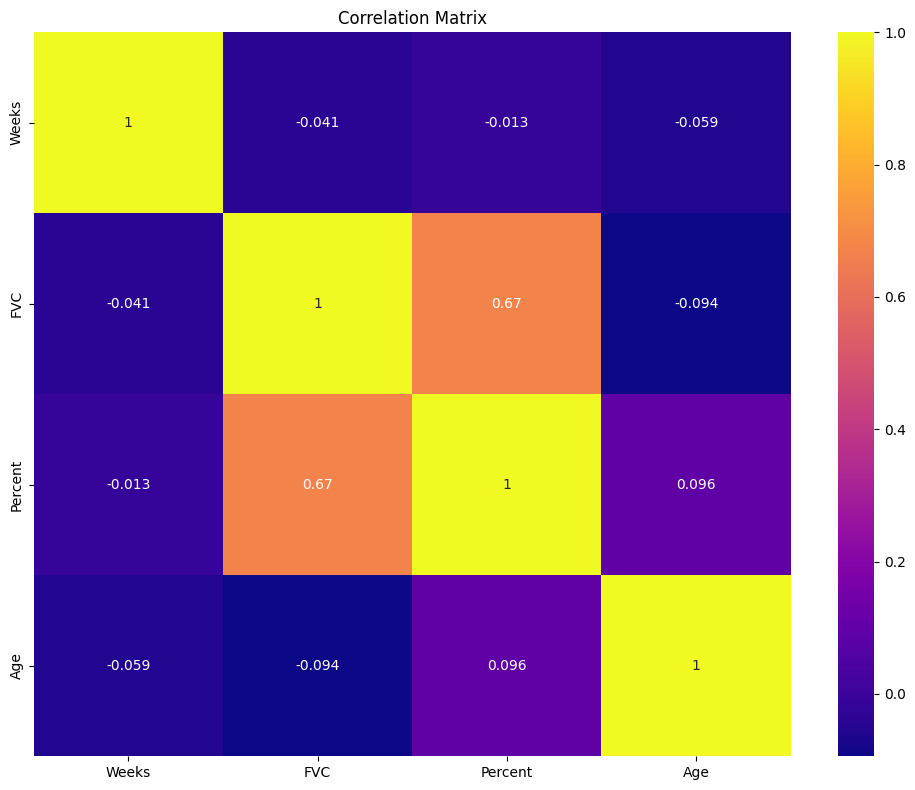

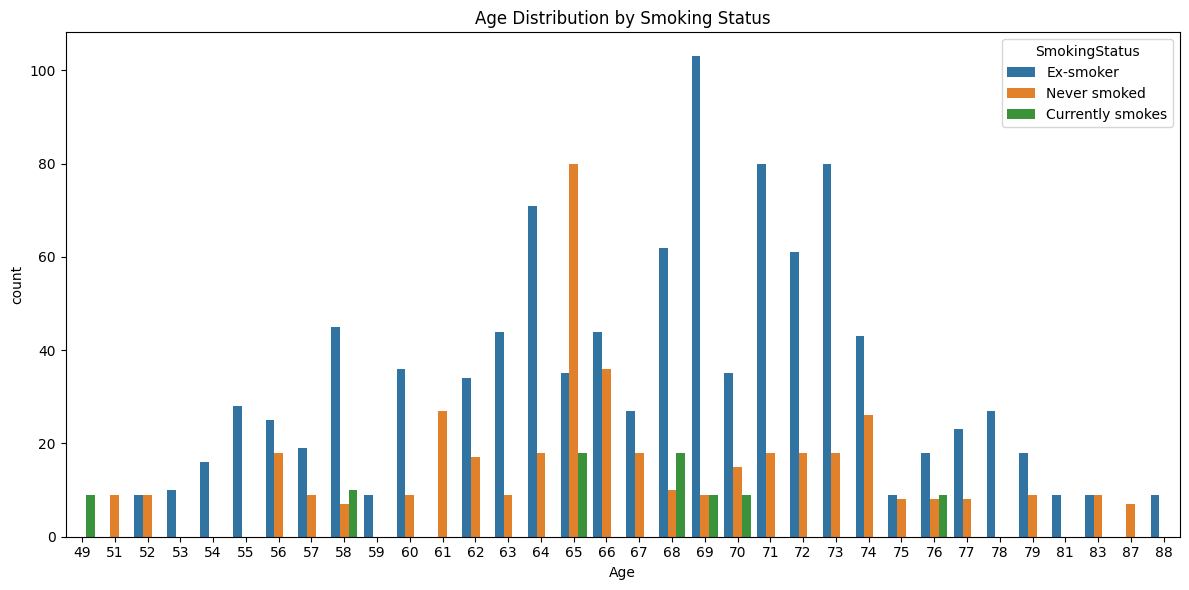

The Number of Unique Patients in training data: 176


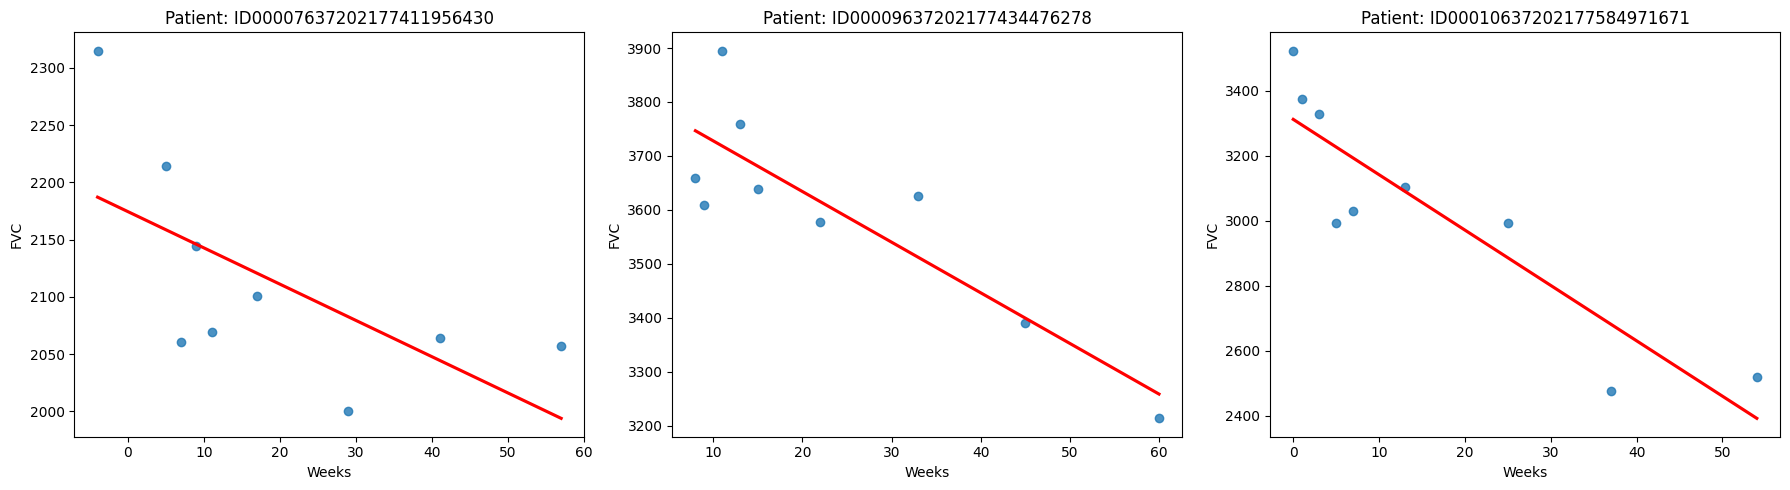

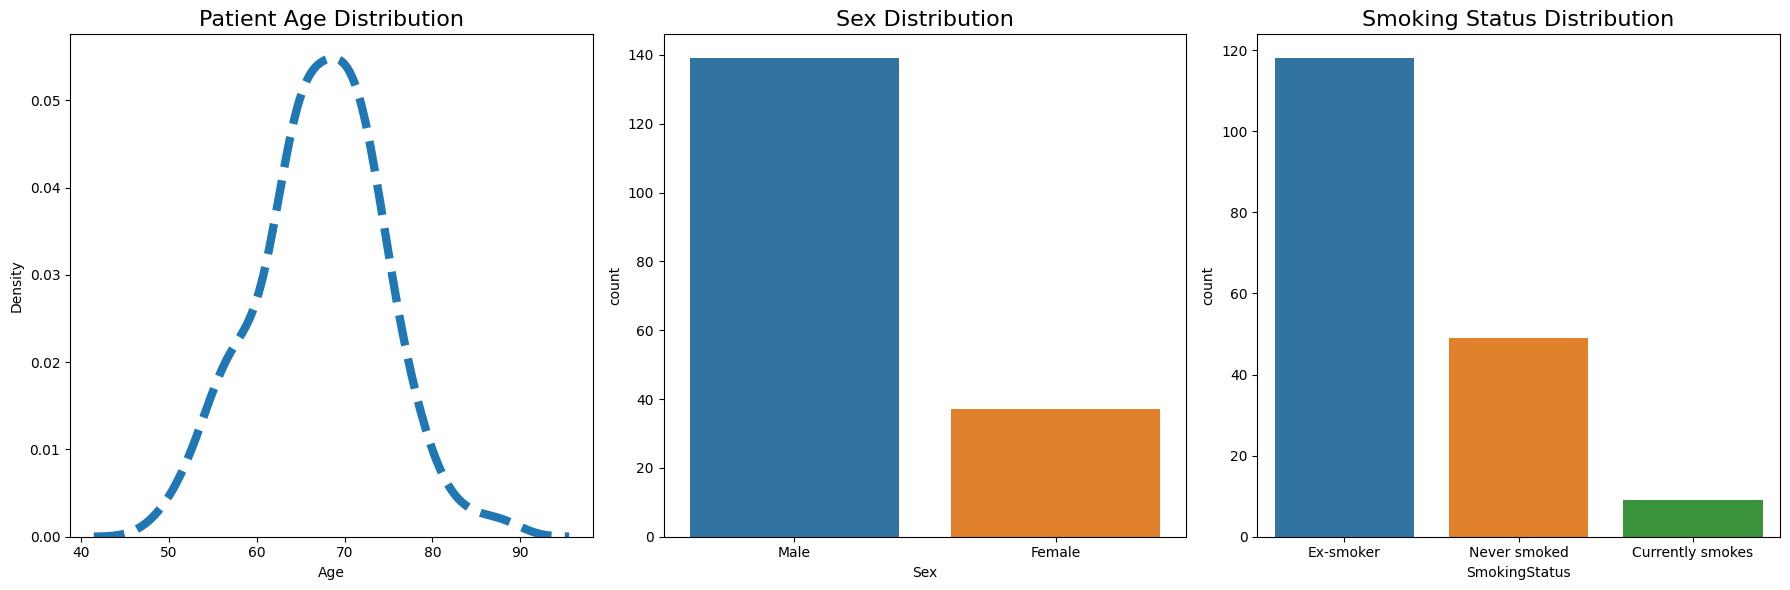

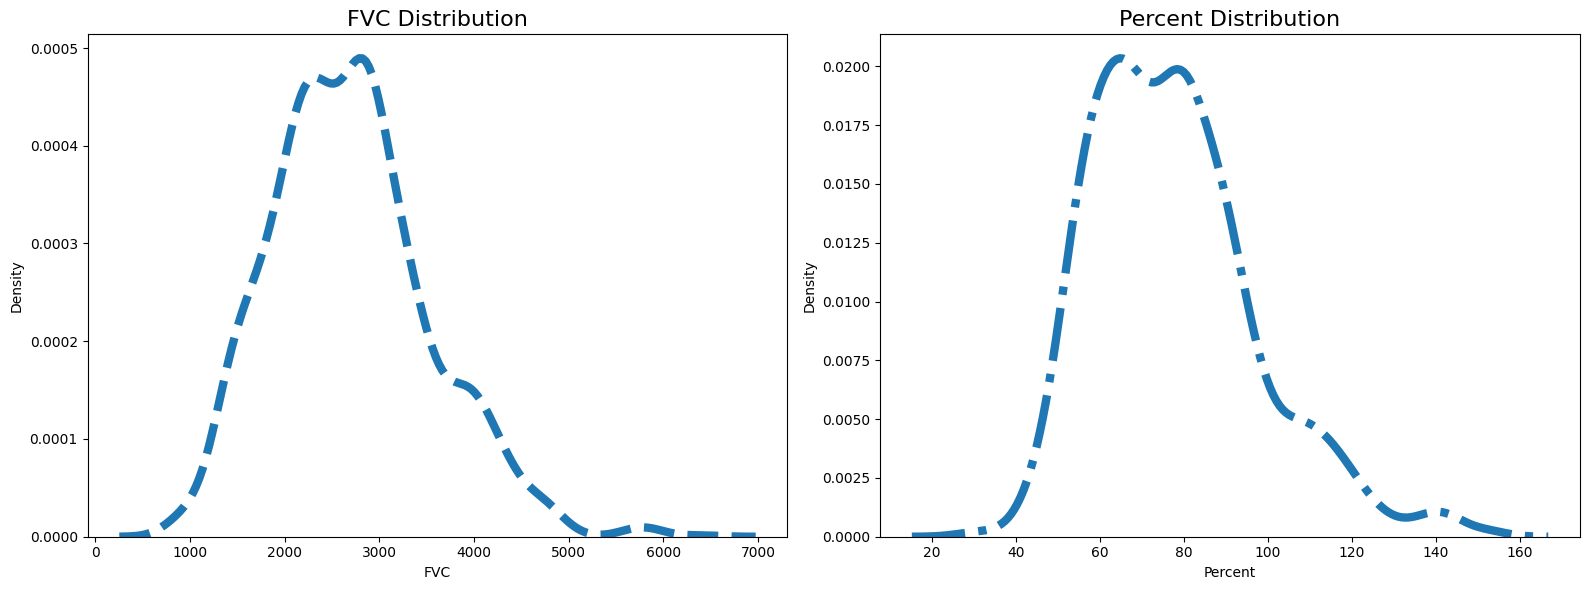

In [17]:
# Part 1: Data Loading and Exploratory Data Analysis
# --------------------------------------------------

# Load datasets
train_df = pd.read_csv(DATA_DIR / 'train.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')

print(f'{train_df.shape[0]} Rows and {train_df.shape[1]} Columns in train data')
print(f'{test_df.shape[0]} Rows and {test_df.shape[1]} Columns in test data')

# Display sample data
print("\nTrain data sample:")
display(train_df.head())

print("\nTest data sample:")
display(test_df.head())

# Descriptive statistics
print("\nTrain data statistics:")
display(train_df.describe())

# Data visualizations
plt.figure(figsize=(10, 8))
numeric_cols = train_df.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True, cmap=plt.cm.plasma)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Patient demographics
plt.figure(figsize=(12, 6))
sns.countplot(x='Age', hue='SmokingStatus', data=train_df)
plt.title('Age Distribution by Smoking Status')
plt.tight_layout()
plt.show()

# Uniqueness check
unique_patients = train_df['Patient'].nunique()
print(f'The Number of Unique Patients in training data: {unique_patients}')

# FVC decline visualization
def chart_patient_data(patient_id, ax):
    plot_data = train_df[train_df['Patient']==patient_id]
    ax.set_title(f"Patient: {patient_id}")
    return sns.regplot(x='Weeks', y='FVC', data=plot_data, ax=ax, 
                       ci=None, line_kws={'color':'red'})

# Sample 3 patients
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
patients_to_plot = train_df['Patient'].unique()[:3]
for i, patient in enumerate(patients_to_plot):
    chart_patient_data(patient, axes[i])
plt.tight_layout()
plt.show()

# Patient demographics visualization
# Select unique bio info for the patients
patient_info = train_df.groupby(by="Patient")[["Patient", "Age", "Sex", "SmokingStatus"]].first().reset_index(drop=True)

# Figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

sns.distplot(patient_info["Age"], ax=ax1, hist=False, kde_kws=dict(lw=6, ls="--"))
sns.countplot(x="Sex", data=patient_info, ax=ax2)
sns.countplot(x="SmokingStatus", data=patient_info, ax=ax3)

ax1.set_title("Patient Age Distribution", fontsize=16)
ax2.set_title("Sex Distribution", fontsize=16)
ax3.set_title("Smoking Status Distribution", fontsize=16)
plt.tight_layout()
plt.show()

# FVC and Percent distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.distplot(train_df["FVC"], ax=ax1, hist=False, kde_kws=dict(lw=6, ls="--"))
sns.distplot(train_df["Percent"], ax=ax2, hist=False, kde_kws=dict(lw=6, ls="-."))

ax1.set_title("FVC Distribution", fontsize=16)
ax2.set_title("Percent Distribution", fontsize=16)
plt.tight_layout()
plt.show()

Calculating linear decay coefficients...


100%|██████████| 176/176 [00:00<00:00, 1493.78it/s]

Processed 176 patients with decay coefficients


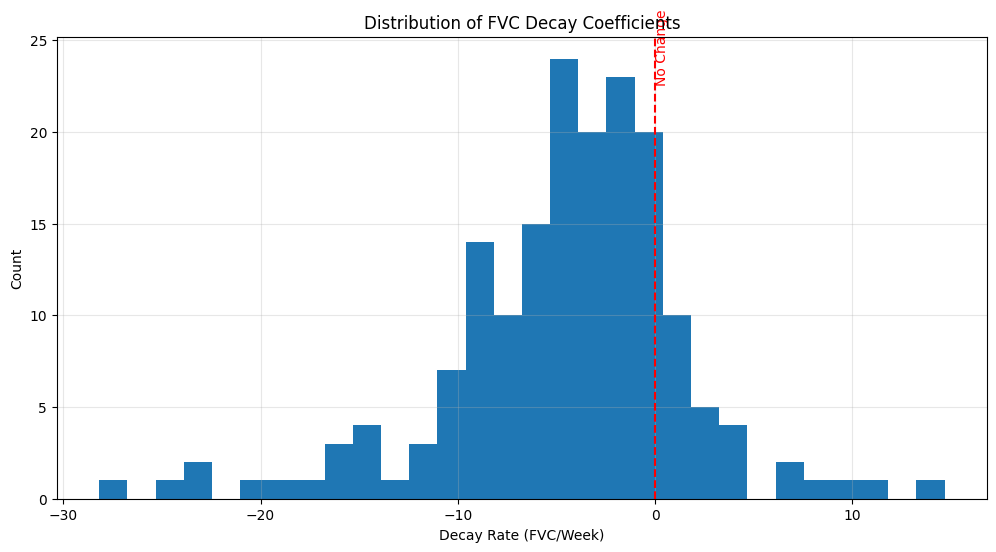

In [18]:
# Part 2: Feature Engineering and Model Preparation
# -------------------------------------------------

# Calculate linear decay coefficients for each patient
print("Calculating linear decay coefficients...")
A = {}  # Decay coefficients
TAB = {}  # Tabular features
P = []  # Patient list

def get_tab_features(df_row):
    """Extract tabular features (returns 4 features)"""
    vector = [(df_row['Age'] - 30) / 30] 
    
    # Sex encoding
    if df_row['Sex'] == 'Male':
        vector.append(0)
    else:
        vector.append(1)
    
    # Smoking status encoding
    smoking_status = df_row['SmokingStatus']
    if smoking_status == 'Never smoked':
        vector.extend([0, 0])
    elif smoking_status == 'Ex-smoker':
        vector.extend([1, 1])
    elif smoking_status == 'Currently smokes':
        vector.extend([0, 1])
    else:
        vector.extend([1, 0])
    return np.array(vector)

for patient in tqdm(train_df['Patient'].unique()):
    sub = train_df[train_df['Patient'] == patient].copy()
    fvc = sub['FVC'].values
    weeks = sub['Weeks'].values
    
    if len(weeks) > 1:
        c = np.vstack([weeks, np.ones(len(weeks))]).T
        try:
            a, b = np.linalg.lstsq(c, fvc, rcond=None)[0]
            A[patient] = a
            TAB[patient] = get_tab_features(sub.iloc[0])
            P.append(patient)
        except:
            # Use fallback method for patients with insufficient data
            A[patient] = (fvc[-1] - fvc[0]) / (weeks[-1] - weeks[0]) if len(weeks) > 1 else 0.0
            TAB[patient] = get_tab_features(sub.iloc[0])
            P.append(patient)
    else:
        A[patient] = 0.0
        TAB[patient] = get_tab_features(sub.iloc[0])
        P.append(patient)

print(f"Processed {len(P)} patients with decay coefficients")

# Visualize decay coefficients
plt.figure(figsize=(12, 6))
plt.hist(list(A.values()), bins=30)
plt.title("Distribution of FVC Decay Coefficients")
plt.xlabel("Decay Rate (FVC/Week)")
plt.ylabel("Count")
plt.axvline(0, color='red', linestyle='--')
plt.text(0, plt.ylim()[1]*0.9, "No Change", rotation=90, color='red')
plt.grid(alpha=0.3)
plt.show()

In [19]:
# Part 3: DICOM Image Exploration and Processing
# ----------------------------------------------

# Load sample DICOM images for visualization
train_image_files = sorted(glob.glob(os.path.join(TRAIN_DIR, '*', '*.dcm')))
print(f'Found {len(train_image_files)} DICOM images')

# Function to load scan and convert to Hounsfield Units
def load_scan(path):
    """Load DICOM slices from a folder"""
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    """Convert DICOM to Hounsfield Units (HU)"""
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    
    # Set out-of-scan pixels to 0
    image[image == -2000] = 0
    
    # Convert to HU
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# Load sample patient scans
sample_patient_id = P[0]
sample_patient_path = os.path.join(TRAIN_DIR, sample_patient_id)
if os.path.exists(sample_patient_path):
    sample_scans = load_scan(sample_patient_path)
    sample_images_hu = get_pixels_hu(sample_scans)
    
    # Display some slices
    num_slices = min(5, len(sample_images_hu))
    fig, axes = plt.subplots(1, num_slices, figsize=(20, 5))
    for i in range(num_slices):
        axes[i].imshow(sample_images_hu[i], cmap=plt.cm.bone)
        axes[i].set_title(f"Slice {i+1}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    # Create an animated view
    def set_lungwin(img, hu=[-1200., 600.]):
        """Adjust window for lung visualization"""
        lungwin = np.array(hu)
        newimg = (img-lungwin[0]) / (lungwin[1]-lungwin[0])
        newimg[newimg < 0] = 0
        newimg[newimg > 1] = 1
        newimg = (newimg * 255).astype('uint8')
        return newimg
    
    # Create a lung mask function combining both approaches
    def make_lungmask(img, display=False):
        """Create a mask of the lungs in the image"""
        row_size = img.shape[0]
        col_size = img.shape[1]
        
        # Normalize image
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std
        
        # Find average pixel value near lungs for normalization
        middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
        mean = np.mean(middle)  
        max_val = np.max(img)
        min_val = np.min(img)
        
        # Adjust outliers
        img[img==max_val] = mean
        img[img==min_val] = mean
        
        # Use KMeans to separate foreground and background
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)
        
        # Morphological operations to refine mask
        eroded = morphology.erosion(thresh_img, np.ones([3,3]))
        dilation = morphology.dilation(eroded, np.ones([8,8]))
        
        # Label regions
        labels = measure.label(dilation)
        regions = measure.regionprops(labels)
        
        # Select lung regions
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if (B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and 
                B[0]>row_size/5 and B[2]<col_size/5*4):
                good_labels.append(prop.label)
                
        # Create final mask
        mask = np.zeros([row_size,col_size], dtype=np.int8)
        for n in good_labels:
            mask = mask + np.where(labels==n,1,0)
            
        # Final dilation
        mask = morphology.dilation(mask, np.ones([10,10]))
        
        # Display steps if requested
        if display:
            fig, ax = plt.subplots(3, 2, figsize=[12, 12])
            ax[0, 0].set_title("Original")
            ax[0, 0].imshow(img, cmap='gray')
            ax[0, 0].axis('off')
            ax[0, 1].set_title("Threshold")
            ax[0, 1].imshow(thresh_img, cmap='gray')
            ax[0, 1].axis('off')
            ax[1, 0].set_title("After Erosion and Dilation")
            ax[1, 0].imshow(dilation, cmap='gray')
            ax[1, 0].axis('off')
            ax[1, 1].set_title("Color Labels")
            ax[1, 1].imshow(labels)
            ax[1, 1].axis('off')
            ax[2, 0].set_title("Final Mask")
            ax[2, 0].imshow(mask, cmap='gray')
            ax[2, 0].axis('off')
            ax[2, 1].set_title("Apply Mask on Original")
            ax[2, 1].imshow(mask*img, cmap='gray')
            ax[2, 1].axis('off')
            plt.tight_layout()
            plt.show()
            
        return mask*img
    
    # Apply lung mask to a sample image
    if len(sample_images_hu) > 0:
        mask_img = make_lungmask(sample_images_hu[len(sample_images_hu)//2], display=True)


Found 33026 DICOM images


AttributeError: module 'pydicom' has no attribute 'read_file'

In [ ]:
# Part 4: Advanced Data Augmentation for Deep Learning
# ---------------------------------------------------

class MedicalAugmentation:
    def __init__(self, augment=True):
        if augment:
            self.transform = albu.Compose([
                # Geometric augmentations
                albu.Rotate(limit=15, p=0.7),
                albu.HorizontalFlip(p=0.5),
                albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.7),
                
                # Medical-specific augmentations
                albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
                albu.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
                albu.RandomGamma(gamma_limit=(80, 120), p=0.5),
                
                # Lung-specific augmentations for robustness
                albu.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
                albu.OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=0.3),
                
                # Cutout for robustness
                albu.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),
                
                # Normalization
                albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            self.transform = albu.Compose([
                albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
    
    def __call__(self, image):
        return self.transform(image=image)['image']

In [ ]:
# Part 5: Dataset Class
# --------------------

class OSICDenseNetDataset(Dataset):
    """Enhanced dataset with medical augmentations and robust loading"""
    
    def __init__(self, patients, A_dict, TAB_dict, data_dir, split='train', augment=True):
        self.patients = [p for p in patients if p not in ['ID00011637202177653955184', 'ID00052637202186188008618']]
        self.A_dict = A_dict
        self.TAB_dict = TAB_dict
        self.data_dir = Path(data_dir)
        self.split = split
        self.augment = augment
        self.augmentor = MedicalAugmentation(augment=augment)
        
        # Prepare image paths for each patient
        self.patient_images = {}
        for patient in self.patients:
            patient_dir = self.data_dir / patient
            if patient_dir.exists():
                image_files = [f for f in patient_dir.iterdir() if f.suffix.lower() == '.dcm']
                if image_files:
                    self.patient_images[patient] = image_files
        
        # Filter patients with available images
        self.valid_patients = [p for p in self.patients if p in self.patient_images]
        print(f"Dataset {split}: {len(self.valid_patients)} patients with images")
    
    def __len__(self):
        # For training, use multiple samples per patient
        if self.split == 'train':
            return len(self.valid_patients) * 6  # More augmented samples
        else:
            return len(self.valid_patients)
    
    def __getitem__(self, idx):
        if self.split == 'train':
            patient_idx = idx % len(self.valid_patients)
        else:
            patient_idx = idx
            
        patient = self.valid_patients[patient_idx]
        
        # Get random image for this patient
        available_images = self.patient_images[patient]
        if len(available_images) > 1:
            selected_image = np.random.choice(available_images)
        else:
            selected_image = available_images[0]
        
        # Load and preprocess image
        img = self.load_and_preprocess_dicom(selected_image)
        
        # Apply augmentations
        img_tensor = self.augmentor(img)
        
        # Get tabular features
        tab_features = torch.tensor(self.TAB_dict[patient], dtype=torch.float32)
        
        # Get target (decay coefficient)
        target = torch.tensor(self.A_dict[patient], dtype=torch.float32)
        
        return img_tensor, tab_features, target, patient
    
    def load_and_preprocess_dicom(self, path):
        """Enhanced DICOM loading with better preprocessing"""
        try:
            # Load DICOM
            dcm = pydicom.dcmread(str(path))
            img = dcm.pixel_array.astype(np.float32)
            
            # Handle different DICOM formats
            if len(img.shape) == 3:
                img = img[img.shape[0]//2]  # Take middle slice if 3D
            
            # Resize to target size
            img = cv2.resize(img, (512, 512))
            
            # Normalize to 0-255 range
            img_min, img_max = img.min(), img.max()
            if img_max > img_min:
                img = (img - img_min) / (img_max - img_min) * 255
            else:
                img = np.zeros_like(img)
            
            # Convert to 3-channel
            img = np.stack([img, img, img], axis=2).astype(np.uint8)
            
            return img
            
        except Exception as e:
            print(f"Error loading DICOM {path}: {e}")
            # Return a black image as fallback
            return np.zeros((512, 512, 3), dtype=np.uint8)


In [20]:
# Part 6: Model Architecture
# -------------------------

# Helper classes for the model
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_cat = self.conv1(x_cat)
        return x * self.sigmoid(x_cat)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

# Main model
class WorkingDenseNetModel(nn.Module):
    """
    DenseNet model with attention mechanisms and uncertainty estimation
    """
    
    def __init__(self, tabular_dim=4, dropout_rate=0.4):
        super(WorkingDenseNetModel, self).__init__()
        
        # DenseNet121 backbone
        densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.features = densenet.features
        
        # Spatial attention
        self.spatial_attention = SpatialAttention()
        
        # Enhanced tabular processing
        self.tabular_processor = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),  # Increased to 256
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),  # Final tabular features: 512
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        # Cross-modal attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=1024, num_heads=8, dropout=0.2, batch_first=True
        )
        
        # Multi-modal fusion
        self.fusion_layer = nn.Sequential(
            nn.Linear(1024 + 512, 768),  # 1024 (img) + 512 (tab) = 1536 -> 768
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2)
        )
        
        # Uncertainty quantification heads
        self.mean_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.log_var_head = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
        
    def forward(self, images, tabular):
        batch_size = images.size(0)
        
        # Extract image features
        img_features = self.features(images)  # [B, 1024, H, W]
        
        # Apply spatial attention
        img_features = self.spatial_attention(img_features)
        
        # Global average pooling
        img_features = F.adaptive_avg_pool2d(img_features, (1, 1))
        img_features = img_features.view(batch_size, -1)  # [B, 1024]
        
        # Process tabular data
        tab_features = self.tabular_processor(tabular)  # [B, 512]
        
        # Cross-modal attention
        img_expanded = img_features.unsqueeze(1)  # [B, 1, 1024]
        tab_expanded = tab_features.unsqueeze(1)  # [B, 1, 512]
        
        # Project tabular to same dimension for attention
        tab_proj = F.linear(tab_expanded, 
                           torch.randn(1024, 512).to(images.device))  # [B, 1, 1024]
        
        attended_img, _ = self.cross_attention(
            img_expanded, tab_proj, tab_proj
        )
        attended_img = attended_img.squeeze(1)  # [B, 1024]
        
        # Fusion
        combined_features = torch.cat([attended_img, tab_features], dim=1)  # [B, 1536]
        fused_features = self.fusion_layer(combined_features)
        
        # Predict mean and log variance
        mean_pred = self.mean_head(fused_features)
        log_var = self.log_var_head(fused_features)
        
        return mean_pred.squeeze(), log_var.squeeze()

# Initialize model
model = WorkingDenseNetModel(tabular_dim=4).to(DEVICE)
print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")


Model initialized with 12,756,452 parameters


In [21]:
# Part 7: Data Split and Loaders
# -----------------------------

# Split patients into train and validation
from sklearn.model_selection import train_test_split

patients_list = list(P)
train_patients, val_patients = train_test_split(
    patients_list, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"Train patients: {len(train_patients)}")
print(f"Validation patients: {len(val_patients)}")

# Create datasets
train_dataset = OSICDenseNetDataset(
    patients=train_patients,
    A_dict=A,
    TAB_dict=TAB,
    data_dir=TRAIN_DIR,
    split='train',
    augment=True
)

val_dataset = OSICDenseNetDataset(
    patients=val_patients,
    A_dict=A,
    TAB_dict=TAB,
    data_dir=TRAIN_DIR,
    split='val',
    augment=False
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False
)


print(f"Data loaders created: {len(train_loader)} training batches, {len(val_loader)} validation batches")


Train patients: 140
Validation patients: 36
Dataset train: 138 patients with images
Dataset val: 36 patients with images
Data loaders created: 103 training batches, 5 validation batches


In [22]:
# Part 8: Training with Uncertainty
# --------------------------------

class CorrectedSimpleTrainer:
    """
    Trainer with proper sigma learning and uncertainty estimation
    """
    
    def __init__(self, model, device, lr=1e-4):
        self.model = model
        self.device = device
        self.lr = lr
        self.best_val_mae = float('inf')
        self.best_val_lll = float('-inf')  # For actual log-likelihood (negative values)
        
    def uncertainty_loss(self, mean_pred, log_var, targets, reduction='mean'):
        """Uncertainty-aware loss function"""
        var = torch.exp(log_var)
        mse_loss = (mean_pred - targets) ** 2
        
        # Add penalty for poor uncertainty estimation
        uncertainty_penalty = torch.mean(torch.abs(log_var - torch.log(mse_loss + 1e-6)))
        
        loss = 0.5 * (mse_loss / var + log_var) + 0.05 * uncertainty_penalty
        
        if reduction == 'mean':
            return loss.mean()
        return loss.sum()
        
    def laplace_log_likelihood(self, y_true, y_pred, log_var):
        """
        Calculate ACTUAL Laplace Log Likelihood
        Returns actual log-likelihood (negative values, higher is better)
        """
        # Convert log variance to standard deviation (sigma)
        sigma = torch.exp(log_var / 2.0)
        
        # Allow dynamic learning with reasonable bounds
        sigma = torch.clamp(sigma, min=2.0, max=200.0)
        
        abs_errors = torch.abs(y_true - y_pred)
        
        # ACTUAL log-likelihood: log(1/(2σ)) - |y-μ|/σ
        # = -log(2σ) - |y-μ|/σ
        log_likelihood = -torch.log(2.0 * sigma) - abs_errors / sigma
        
        # Return ACTUAL log-likelihood (negative values, higher is better)
        return torch.mean(log_likelihood)
        
    def train(self, train_loader, val_loader, epochs=30, patience=8):
        # Better optimizer settings for uncertainty learning
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=5e-5,  # Lower learning rate for better uncertainty learning
            weight_decay=1e-5
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=4, verbose=True  # mode='max' for log-likelihood
        )
        
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_mae = 0.0
            train_lll = 0.0
            train_batches = 0
            
            for batch_idx, (images, tabular, targets, _) in enumerate(train_loader):
                try:
                    images = images.to(self.device)
                    tabular = tabular.to(self.device) 
                    targets = targets.to(self.device)
                    
                    optimizer.zero_grad()
                    
                    # Forward pass
                    mean_pred, log_var = self.model(images, tabular)
                    
                    # Calculate losses and metrics
                    loss = self.uncertainty_loss(mean_pred, log_var, targets)
                    mae = F.l1_loss(mean_pred, targets)
                    lll = self.laplace_log_likelihood(targets, mean_pred, log_var)
                    
                    # Backward pass
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    optimizer.step()
                    
                    train_loss += loss.item()
                    train_mae += mae.item()
                    train_lll += lll.item()
                    train_batches += 1
                    
                except Exception as e:
                    print(f"Error in training batch {batch_idx}: {e}")
                    continue
            
            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_mae = 0.0
            val_lll = 0.0
            val_predictions = []
            val_targets = []
            val_sigmas = []
            
            with torch.no_grad():
                for batch_idx, (images, tabular, targets, _) in enumerate(val_loader):
                    try:
                        images = images.to(self.device)
                        tabular = tabular.to(self.device)
                        targets = targets.to(self.device)
                        
                        mean_pred, log_var = self.model(images, tabular)
                        
                        # Calculate all metrics
                        loss = self.uncertainty_loss(mean_pred, log_var, targets)
                        mae = F.l1_loss(mean_pred, targets)
                        lll = self.laplace_log_likelihood(targets, mean_pred, log_var)
                        
                        # Calculate sigma values for debugging
                        sigma = torch.exp(log_var / 2.0)
                        sigma = torch.clamp(sigma, min=2.0, max=200.0)
                        
                        val_loss += loss.item()
                        val_mae += mae.item()
                        val_lll += lll.item()
                        
                        val_predictions.extend(mean_pred.cpu().numpy())
                        val_targets.extend(targets.cpu().numpy())
                        val_sigmas.extend(sigma.cpu().numpy())
                        
                    except Exception as e:
                        print(f"Error in validation batch {batch_idx}: {e}")
                        continue
            
            # Calculate comprehensive metrics
            if train_batches > 0 and len(val_predictions) > 0:
                # Average training metrics
                avg_train_loss = train_loss / train_batches
                avg_train_mae = train_mae / train_batches
                avg_train_lll = train_lll / train_batches
                
                # Average validation metrics
                avg_val_loss = val_loss / len(val_loader)
                avg_val_mae = val_mae / len(val_loader)
                avg_val_lll = val_lll / len(val_loader)
                
                # Convert to numpy arrays for additional metrics
                val_predictions = np.array(val_predictions)
                val_targets = np.array(val_targets)
                val_sigmas = np.array(val_sigmas)
                
                # Calculate RMSE
                val_rmse = np.sqrt(np.mean((val_predictions - val_targets) ** 2))
                
                # Calculate R²
                ss_res = np.sum((val_targets - val_predictions) ** 2)
                ss_tot = np.sum((val_targets - np.mean(val_targets)) ** 2)
                r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else -float('inf')
                
                # Sigma statistics
                avg_sigma = np.mean(val_sigmas)
                min_sigma = np.min(val_sigmas)
                max_sigma = np.max(val_sigmas)
                
                # Enhanced printing with all metrics and debugging info
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"Train Loss: {avg_train_loss:.6f} | Train LLL: {avg_train_lll:.6f} | Train MAE: {avg_train_mae:.6f}")
                print(f"Val Loss: {avg_val_loss:.6f} | Val LLL: {avg_val_lll:.6f} | MAE: {avg_val_mae:.6f} | RMSE: {val_rmse:.6f} | R²: {r2:.6f}")
                print(f"Sigma Stats: Avg={avg_sigma:.2f}, Range=[{min_sigma:.2f}, {max_sigma:.2f}]")
                
                # Learning rate scheduling (using log-likelihood now)
                scheduler.step(avg_val_lll)
                
                # Early stopping and model saving (using actual LLL - higher is better)
                if avg_val_lll > self.best_val_lll:  # Higher log-likelihood is better
                    self.best_val_lll = avg_val_lll
                    self.best_val_mae = avg_val_mae
                    torch.save(self.model.state_dict(), 'best_model.pth')
                    print("✅ New best model saved! (Best Log Likelihood)")
                    patience_counter = 0
                else:
                    patience_counter += 1
                    
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
                    
                print("-" * 70)
        
        return self.best_val_mae

In [23]:
# Part 9: Submission Generation with Confidence
# -------------------------------------------

class TTAPredictor:
    """Test-time augmentation for more robust predictions"""
    def __init__(self, model, num_augmentations=5):
        self.model = model
        self.num_augmentations = num_augmentations
        self.augmentor = MedicalAugmentation(augment=True)
        self.model.eval()
    
    def predict(self, image, tabular):
        # Original prediction
        with torch.no_grad():
            mean_pred, log_var = self.model(image.unsqueeze(0), tabular.unsqueeze(0))
            mean_preds = [mean_pred.item()]
            log_vars = [log_var.item()]
        
        # Augmented predictions
        for _ in range(self.num_augmentations):
            try:
                # Apply augmentation
                aug_img = self.augmentor(image.permute(1, 2, 0).numpy().astype(np.uint8))
                aug_img = aug_img.to(image.device)
                
                # Predict
                with torch.no_grad():
                    mean_pred, log_var = self.model(aug_img.unsqueeze(0), tabular.unsqueeze(0))
                    mean_preds.append(mean_pred.item())
                    log_vars.append(log_var.item())
                    
            except Exception as e:
                print(f"Error in TTA: {e}")
                continue
        
        # Ensemble predictions
        mean_ensemble = np.median(mean_preds)
        log_var_ensemble = np.median(log_vars)
        
        # Calculate uncertainty (standard deviation)
        std = np.sqrt(np.exp(log_var_ensemble))
        
        return mean_ensemble, std

def create_submission_with_confidence(model, test_dir, output_file='submission.csv'):
    """Create submission with confidence intervals"""
    print(f"📝 Creating submission with confidence intervals...")
    
    # Load test data
    test_df = pd.read_csv(DATA_DIR / 'test.csv')
    print(f"✅ Loaded test data: {len(test_df)} samples")
    
    submissions = []
    model.eval()
    
    # Create augmentor for test time augmentation
    test_augmentor = MedicalAugmentation(augment=False)
    
    print("🔄 Processing test patients...")
    
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing"):
        patient_id = row['Patient']
        weeks = row['Weeks']
        
        try:
            # Load patient image
            patient_dir = Path(test_dir) / patient_id
            
            # Default prediction values
            fvc_pred = 2000.0  # Default FVC
            confidence_val = 200.0  # Default confidence
            
            if patient_dir.exists():
                image_files = list(patient_dir.glob('*.dcm'))
                if image_files:
                    # Load and preprocess image
                    img = load_and_preprocess_dicom(image_files[0])
                    img_tensor = test_augmentor(img).unsqueeze(0).to(DEVICE)
                    
                    # Prepare tabular features
                    tab_features = get_tab_features(row)
                    tab_tensor = torch.tensor(tab_features).float().unsqueeze(0).to(DEVICE)
                    
                    # Predict with uncertainty
                    with torch.no_grad():
                        mean_pred, log_var = model(img_tensor, tab_tensor)
                        fvc_pred = mean_pred.item()
                        confidence_val = max(torch.exp(log_var/2).item() * 70, 70)  # Scale and set minimum
            
            # Create submission rows for required weeks
            for week in range(-12, 134):  # Standard competition range
                patient_week = f"{patient_id}_{week}"
                
                # Adjust prediction based on time progression
                if patient_id in A:
                    time_adjusted_fvc = fvc_pred + (week - weeks) * A[patient_id]
                else:
                    time_adjusted_fvc = fvc_pred + (week - weeks) * (-7)  # Default decay
                
                # Ensure reasonable bounds
                time_adjusted_fvc = max(time_adjusted_fvc, 800)  # Minimum FVC
                time_adjusted_fvc = min(time_adjusted_fvc, 6000)  # Maximum FVC
                
                submissions.append({
                    'Patient_Week': patient_week,
                    'FVC': time_adjusted_fvc,
                    'Confidence': confidence_val
                })
                
        except Exception as e:
            print(f"⚠️ Error processing patient {patient_id}: {e}")
            # Use default values for this patient
            for week in range(-12, 134):
                patient_week = f"{patient_id}_{week}"
                submissions.append({
                    'Patient_Week': patient_week,
                    'FVC': 2000.0,
                    'Confidence': 200.0
                })
    
    # Create submission dataframe
    submission_df = pd.DataFrame(submissions)
    submission_df.to_csv(output_file, index=False)
    
    print(f"✅ Submission saved to {output_file}")
    print(f"📊 Submission stats:")
    print(f"   Total rows: {len(submission_df)}")
    print(f"   FVC range: {submission_df['FVC'].min():.1f} - {submission_df['FVC'].max():.1f}")
    print(f"   Confidence range: {submission_df['Confidence'].min():.1f} - {submission_df['Confidence'].max():.1f}")
    
    return submission_df

# Helper function for DICOM loading (for submission)
def load_and_preprocess_dicom(path):
    """Simplified DICOM loading for submission"""
    try:
        dcm = pydicom.dcmread(str(path))
        img = dcm.pixel_array.astype(np.float32)
        
        if len(img.shape) == 3:
            img = img[img.shape[0]//2]
        
        img = cv2.resize(img, (512, 512))
        
        # Normalize to 0-255
        img_min, img_max = img.min(), img.max()
        if img_max > img_min:
            img = (img - img_min) / (img_max - img_min) * 255
        else:
            img = np.zeros_like(img)
        
        # Convert to 3-channel
        img = np.stack([img, img, img], axis=2).astype(np.uint8)
        return img
        
    except Exception as e:
        # Return black image as fallback
        return np.zeros((512, 512, 3), dtype=np.uint8)

In [25]:
# Part 10: Execute Training (Uncomment to run)
# ------------------------------------------

print("🚀 Starting training...")
trainer = CorrectedSimpleTrainer(model, DEVICE, lr=5e-5)
best_val_mae = trainer.train(train_loader, val_loader, epochs=30, patience=8)
print(f"🎯 Training completed! Best validation MAE: {best_val_mae:.6f}")

# Generate submission
print("📝 Generating submission...")
final_submission = create_submission_with_confidence(model, TRAIN_DIR, 'enhanced_submission.csv')
print("✅ Submission ready!")

🚀 Starting training...
Epoch 1/30
Train Loss: 2.481594 | Train LLL: -3.141354 | Train MAE: 4.158898
Val Loss: 3.308170 | Val LLL: -3.426351 | MAE: 5.077740 | RMSE: 7.262148 | R²: -0.019706
Sigma Stats: Avg=4.01, Range=[2.00, 5.84]
✅ New best model saved! (Best Log Likelihood)
----------------------------------------------------------------------
Epoch 2/30
Train Loss: 2.472780 | Train LLL: -3.133015 | Train MAE: 4.139636
Val Loss: 3.398581 | Val LLL: -3.395731 | MAE: 4.895314 | RMSE: 7.260303 | R²: -0.019187
Sigma Stats: Avg=4.22, Range=[2.48, 6.75]
✅ New best model saved! (Best Log Likelihood)
----------------------------------------------------------------------
Epoch 3/30
Train Loss: 2.455098 | Train LLL: -3.133223 | Train MAE: 4.126816
Val Loss: 3.122260 | Val LLL: -3.368852 | MAE: 5.003200 | RMSE: 7.173733 | R²: 0.004973
Sigma Stats: Avg=4.10, Range=[2.00, 5.83]
✅ New best model saved! (Best Log Likelihood)
----------------------------------------------------------------------
Epo

Processing: 100%|██████████| 5/5 [00:00<00:00, 19.45it/s]

✅ Submission saved to enhanced_submission.csv
📊 Submission stats:
   Total rows: 730
   FVC range: 800.0 - 800.0
   Confidence range: 199.4 - 377.7
✅ Submission ready!


In [34]:
# -------------------------
# LLL evaluation utilities
# -------------------------
import numpy as np
import pandas as pd
import torch
import os
from math import sqrt, log
from tqdm import tqdm

SQRT2 = np.sqrt(2.0)

def laplace_score_per_sample(y_true, y_pred, sigma, sigma_floor=70.0):
    """
    Per-sample Laplace Log-Likelihood (as used in OSIC).
    Inputs are numpy arrays or scalars.
    sigma is clipped to a minimum of sigma_floor.
    Returns per-sample score (not averaged).
    """
    sigma = np.maximum(sigma, sigma_floor)
    delta = np.abs(y_true - y_pred)
    term1 = - (SQRT2 * delta) / sigma
    term2 = - np.log(SQRT2 * sigma)
    return term1 + term2

def mean_laplace_score(y_true, y_pred, sigma, sigma_floor=70.0):
    arr = laplace_score_per_sample(np.array(y_true), np.array(y_pred), np.array(sigma), sigma_floor=sigma_floor)
    return float(np.mean(arr))

# -------------------------
# Evaluate on a DataLoader
# -------------------------
def evaluate_lll_from_loader(model, loader, device, mode='log_var', tta_predictor=None, sigma_floor=70.0, save_csv=True, out_dir=None):
    """
    mode:
      - 'log_var' : model(images, tabular) -> (mean_pred, log_var). sigma = sqrt(exp(log_var))
      - 'confidence' : model(images, tabular) -> (mean_pred, confidence). confidence used as sigma directly
      - 'tta' : use tta_predictor.predict(image, tabular) -> (mean, std). (std used directly as sigma)
    tta_predictor: instance of TTAPredictor if mode == 'tta'
    Returns: (mean_lll, df) and writes CSV if save_csv True.
    CSV columns: ['patient'(if available), 'y_true', 'y_pred', 'sigma', 'lll']
    """
    model.eval()
    preds = []
    trues = []
    sigmas = []
    patients = []

    device = torch.device(device)

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating LLL"):
            images, tabular, targets, patient_ids = batch
            batch_size = images.shape[0]

            images = images.to(device)
            tabular = tabular.to(device)
            targets = targets.to(device)

            if mode == 'log_var':
                mean_pred, log_var = model(images, tabular)
                mean_np = mean_pred.detach().cpu().numpy().astype(float)
                log_var_np = log_var.detach().cpu().numpy().astype(float)
                sigma_np = np.sqrt(np.exp(log_var_np))
            elif mode == 'confidence':
                mean_pred, confidence = model(images, tabular)
                mean_np = mean_pred.detach().cpu().numpy().astype(float)
                sigma_np = confidence.detach().cpu().numpy().astype(float)
            elif mode == 'tta':
                mean_list = []
                sigma_list = []
                for i in range(batch_size):
                    img = images[i].cpu()
                    tab = tabular[i].cpu()
                    mean_i, sigma_i = tta_predictor.predict(img, tab)
                    mean_list.append(float(mean_i))
                    sigma_list.append(float(sigma_i))
                mean_np = np.array(mean_list, dtype=float)
                sigma_np = np.array(sigma_list, dtype=float)
            else:
                raise ValueError("Unknown mode for evaluate_lll_from_loader")

            targets_np = targets.detach().cpu().numpy().astype(float)

            preds.extend(mean_np.tolist())
            trues.extend(targets_np.tolist())
            sigmas.extend(sigma_np.tolist())
            patients.extend([p if isinstance(p, str) else (p.item().decode('utf-8') if hasattr(p, 'item') else str(p)) for p in patient_ids])

    preds = np.array(preds, dtype=float)
    trues = np.array(trues, dtype=float)
    sigmas = np.array(sigmas, dtype=float)
    lll_per_sample = laplace_score_per_sample(trues, preds, sigmas, sigma_floor=sigma_floor)
    mean_lll = float(np.mean(lll_per_sample))

    df = pd.DataFrame({
        'patient': patients,
        'y_true': trues,
        'y_pred': preds,
        'sigma': sigmas,
        'lll': lll_per_sample
    })

    if save_csv:
        if out_dir is None:
            out_dir = globals().get('auto_save_dir', '.')
        os.makedirs(out_dir, exist_ok=True)
        outpath = os.path.join(out_dir, 'lll_predictions.csv')
        df.to_csv(outpath, index=False)
        print(f"Saved per-sample predictions + lll to: {outpath}")

    print(f"Mean Laplace Log-Likelihood (LLL): {mean_lll:.6f}")
    return mean_lll, df

# -------------------------
# Helper: Convert slope -> FVC predictions and compute LLL per patient-week
# -------------------------
def compute_lll_from_slope_predictions(slope_df, cur_fvc_map, cur_week_map, weeks_to_predict=None, sigma_floor=70.0, save_csv=True, out_dir=None):
    if weeks_to_predict is None:
        weeks_to_predict = np.arange(-12, 134)

    rows = []
    for idx, r in slope_df.iterrows():
        patient = r['Patient']
        slope = float(r['pred_slope'])
        sigma_slope = float(r.get('sigma_slope', 0.0))
        if patient not in cur_fvc_map or patient not in cur_week_map:
            continue
        cur_fvc = float(cur_fvc_map[patient])
        cur_week = int(cur_week_map[patient])

        intercept = cur_fvc - slope * cur_week

        for w in weeks_to_predict:
            pred_fvc = intercept + slope * w
            sigma_fvc = max(1e-6, sigma_slope * abs(w - cur_week))
            rows.append({
                'Patient': patient,
                'Week': w,
                'y_true': None,
                'y_pred': pred_fvc,
                'sigma': sigma_fvc
            })

    df_expanded = pd.DataFrame(rows)
    if save_csv:
        out_dir = out_dir or globals().get('auto_save_dir', '.')
        os.makedirs(out_dir, exist_ok=True)
        df_expanded.to_csv(os.path.join(out_dir, 'slope_to_fvc_expanded.csv'), index=False)
        print(f"Saved expanded slope->FVC predictions to {out_dir}/slope_to_fvc_expanded.csv")
    return df_expanded

# -------------------------
# Example usage after training (run these cells)
# -------------------------
# 1) If your trained model returns (mean_pred, log_var) -> use mode='log_var'
auto_save_dir = "./auto_save_data"
import os
os.makedirs(auto_save_dir, exist_ok=True)
mean_lll, df = evaluate_lll_from_loader(model, val_loader, DEVICE, mode='log_var', out_dir=auto_save_dir)
#
# 2) If you wrapped your model with ModelWithConfidence and it returns (mean_pred, confidence) -> mode='confidence'
wrapped = ModelWithConfidence(base_model)  # load weights as needed
wrapped.load_state_dict(torch.load('model_with_confidence.pth'))  # if saved
wrapped.to(DEVICE).eval()
mean_lll, df = evaluate_lll_from_loader(wrapped, val_loader, DEVICE, mode='confidence', out_dir=auto_save_dir)
#
# 3) If you want to do TTA (slower) using TTAPredictor:
tta = TTAPredictor(model, num_augmentations=5)
mean_lll, df = evaluate_lll_from_loader(model, val_loader, DEVICE, mode='tta', tta_predictor=tta, out_dir=auto_save_dir)
#
# 4) If your model predicts slope, and you have anchor cur_fvc & cur_week (per-patient), create a slope_df:
slope_df = pd.DataFrame([
    {'Patient': p, 'pred_slope': s, 'sigma_slope': ssize}
    for p, s, ssize in zip(patient_list, slope_list, sigma_list)
])
expanded = compute_lll_from_slope_predictions(slope_df, cur_fvc_map, cur_week_map, weeks_to_predict=np.arange(-12,134))
#    # fill expanded['y_true'] with true FVCs if you have them, then compute mean_laplace_score:
mean_lll = mean_laplace_score(expanded['y_true'], expanded['y_pred'], expanded['sigma'], sigma_floor=70.0)


Evaluating LLL: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]

Saved per-sample predictions + lll to: ./auto_save_data/lll_predictions.csv
Mean Laplace Log-Likelihood (LLL): -4.697215


NameError: name 'ModelWithConfidence' is not defined